In [99]:
import tensorflow as tf
import numpy as np

# Set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Option & PDE parameters
r = 0.05            # Interest rate
T = 1.0             # Maturity
K = 100.0           # Strike

# Asset settings
d = 2                            # Number of assets (modifiable)
sigma = [0.25]*d                # Volatilities
sigma1 = sigma[0]
sigma2 = sigma[1]
rho = 0                       # Correlation coefficient
S_low, S_high = 1e-8, 3*K       # Domain bounds
S_multiplier = 1.2
S_upper = S_high * S_multiplier
t_low = 1e-8

# Neural network parameters
n_layers = 5
n_nodes = 100
learning_rate = 1e-4

# Training parameters
n_samples_pde = 7000
n_samples_terminal = 7000
n_epochs = 15000

In [41]:
def payoff(S, kind="put", operator="min"):
    if operator == "max":
        A = tf.reduce_max(S, axis=1, keepdims=True)
    elif operator == "min":
        A = tf.reduce_min(S, axis=1, keepdims=True)
    else:
        raise ValueError("Operator must be 'max' or 'min'")

    if kind == "call":
        return tf.nn.relu(A - K)
    elif kind == "put":
        return tf.nn.relu(K - A)
    else:
        raise ValueError("Kind must be 'call' or 'put'")

In [43]:
class LSTMLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim, trans1=tf.nn.tanh, trans2=tf.nn.tanh):
        super().__init__()
        self.trans1 = trans1
        self.trans2 = trans2
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.Uz = self.add_weight(shape=[input_dim, output_dim], initializer="glorot_uniform", name="Uz")
        self.Ug = self.add_weight(shape=[input_dim, output_dim], initializer="glorot_uniform", name="Ug")
        self.Ur = self.add_weight(shape=[input_dim, output_dim], initializer="glorot_uniform", name="Ur")
        self.Uh = self.add_weight(shape=[input_dim, output_dim], initializer="glorot_uniform", name="Uh")

        self.Wz = self.add_weight(shape=[output_dim, output_dim], initializer="glorot_uniform", name="Wz")
        self.Wg = self.add_weight(shape=[output_dim, output_dim], initializer="glorot_uniform", name="Wg")
        self.Wr = self.add_weight(shape=[output_dim, output_dim], initializer="glorot_uniform", name="Wr")
        self.Wh = self.add_weight(shape=[output_dim, output_dim], initializer="glorot_uniform", name="Wh")

        self.bz = self.add_weight(shape=[1, output_dim], initializer="zeros", name="bz")
        self.bg = self.add_weight(shape=[1, output_dim], initializer="zeros", name="bg")
        self.br = self.add_weight(shape=[1, output_dim], initializer="zeros", name="br")
        self.bh = self.add_weight(shape=[1, output_dim], initializer="zeros", name="bh")

    def call(self, S, X):
        Z = self.trans1(tf.matmul(X, self.Uz) + tf.matmul(S, self.Wz) + self.bz)
        G = self.trans1(tf.matmul(X, self.Ug) + tf.matmul(S, self.Wg) + self.bg)
        R = self.trans1(tf.matmul(X, self.Ur) + tf.matmul(S, self.Wr) + self.br)
        H = self.trans2(tf.matmul(X, self.Uh) + tf.matmul(R * S, self.Wh) + self.bh)
        return (1 - G) * H + Z * S

In [45]:
class DGMNet(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim, n_layers):
        super().__init__()
        self.input_layer = tf.keras.layers.Dense(hidden_dim, activation='tanh')

        self.hidden_layers = [LSTMLayer(input_dim, hidden_dim) for _ in range(n_layers)]
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, t, *S):
        X = tf.concat([t] + list(S), axis=1)
        S_out = self.input_layer(X)

        for lstm in self.hidden_layers:
            S_out = lstm(S_out, X)

        return self.output_layer(S_out)

In [47]:
def sampler(n_pde, n_terminal, d):
    t_pde = np.random.uniform(t_low, T, size=(n_pde, 1))
    S_pde = np.random.uniform(S_low, S_upper, size=(n_pde, d))

    t_terminal = T * np.ones((n_terminal, 1))
    S_terminal = np.random.uniform(S_low, S_upper, size=(n_terminal, d))

    return map(lambda x: tf.convert_to_tensor(x, dtype=tf.float32),
               [t_pde, S_pde, t_terminal, S_terminal])

In [49]:
@tf.function
def compute_loss(model, t_pde, S_pde, t_term, S_term, payoff_kind="put", payoff_op="min"):
    S_split = tf.split(S_pde, d, axis=1)

    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([t_pde] + S_split)

        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([t_pde] + S_split)
            V = model(t_pde, *S_split)

        V_t = tape1.gradient(V, t_pde)
        V_s = [tape1.gradient(V, S_split[i]) for i in range(d)]

    V_ss = [tape2.gradient(V_s[i], S_split[i]) for i in range(d)]

    # Résidu PDE
    pde = V_t
    for i in range(d):
        Si = S_split[i]
        pde += r * Si * V_s[i] + 0.5 * sigma[i]**2 * Si**2 * V_ss[i]
    pde -= r * V

    loss_pde = tf.reduce_mean(tf.square(pde))

    # Terminal loss
    V_terminal = model(t_term, *tf.split(S_term, d, axis=1))
    payoff_target = payoff(S_term, kind=payoff_kind, operator=payoff_op)
    loss_terminal = tf.reduce_mean(tf.square(V_terminal - payoff_target))

    return loss_pde + loss_terminal, loss_pde, loss_terminal

In [51]:
# Initialisation du modèle
model = DGMNet(input_dim=d+1, hidden_dim=n_nodes, n_layers=n_layers)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(t_pde, S_pde, t_term, S_term):
    with tf.GradientTape() as tape:
        loss_total, l_pde, l_term = compute_loss(
            model, t_pde, S_pde, t_term, S_term,
            payoff_kind="put", payoff_op="min"
        )
    grads = tape.gradient(loss_total, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_total, l_pde, l_term


# Entraînement
for epoch in range(n_epochs):
    t_pde, S_pde, t_term, S_term = sampler(
        n_samples_pde, n_samples_terminal, d
    )
    loss_total, l_pde, l_term = train_step(
        t_pde, S_pde, t_term, S_term
    )
    if epoch % 500 == 0:
        print(f"Epoch {epoch:5d} | Total: {loss_total:.5e} | PDE: {l_pde:.2e} | Terminal: {l_term:.2e}")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:1407: UserWarning: Layer 'dgm_net_1' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''DGMNet.call() got an unexpected keyword argument 'S'''
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'dgm_net_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. Th

Epoch     0 | Total: 4.02961e+03 | PDE: 2.26e+03 | Terminal: 1.77e+03
Epoch   500 | Total: 2.39473e+02 | PDE: 3.00e+01 | Terminal: 2.09e+02
Epoch  1000 | Total: 6.10174e+01 | PDE: 1.84e+01 | Terminal: 4.26e+01
Epoch  1500 | Total: 2.81509e+01 | PDE: 1.23e+01 | Terminal: 1.59e+01
Epoch  2000 | Total: 1.61480e+01 | PDE: 8.43e+00 | Terminal: 7.72e+00
Epoch  2500 | Total: 1.12420e+01 | PDE: 6.56e+00 | Terminal: 4.68e+00
Epoch  3000 | Total: 7.72151e+00 | PDE: 4.65e+00 | Terminal: 3.07e+00
Epoch  3500 | Total: 5.96037e+00 | PDE: 3.69e+00 | Terminal: 2.27e+00
Epoch  4000 | Total: 5.38235e+00 | PDE: 3.65e+00 | Terminal: 1.73e+00
Epoch  4500 | Total: 3.89336e+00 | PDE: 2.40e+00 | Terminal: 1.50e+00
Epoch  5000 | Total: 3.47131e+00 | PDE: 2.24e+00 | Terminal: 1.23e+00
Epoch  5500 | Total: 2.73143e+00 | PDE: 1.68e+00 | Terminal: 1.05e+00
Epoch  6000 | Total: 2.52055e+00 | PDE: 1.58e+00 | Terminal: 9.38e-01
Epoch  6500 | Total: 2.32925e+00 | PDE: 1.45e+00 | Terminal: 8.76e-01
Epoch  7000 | Total:

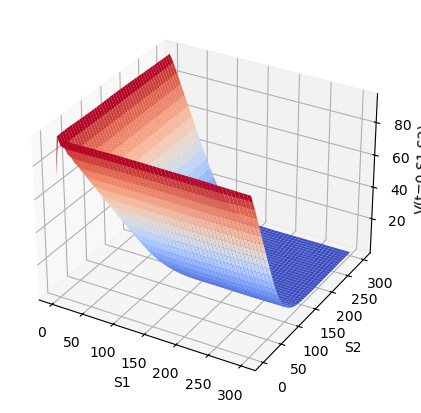

In [63]:
import matplotlib.pyplot as plt

def plot_surface1(model, t_fixed=1.0, d=2, n_grid=50):
    S1 = np.linspace(S_low, S_high, n_grid)
    S2 = np.linspace(S_low, S_high, n_grid)
    S1_grid, S2_grid = np.meshgrid(S1, S2)

    t_plot = t_fixed * np.ones_like(S1_grid)
    inputs = [t_plot.reshape(-1, 1), S1_grid.reshape(-1, 1), S2_grid.reshape(-1, 1)]

    with tf.device("/cpu:0"):  # pour éviter surchauffe GPU
        pred = model(*inputs).numpy().reshape(n_grid, n_grid)

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(S1_grid, S2_grid, pred, cmap="coolwarm")
    ax.set_xlabel("S1")
    ax.set_ylabel("S2")
    ax.set_zlabel(f"V(t={t_fixed},S1,S2)", labelpad=1)
    #ax.set_title(f"Prediction surface at t = {t_fixed}")
    plt.savefig("CH2_PUT_WO_5050_0.png", dpi=300)
    plt.show()

plot_surface1(model,0,d=2)

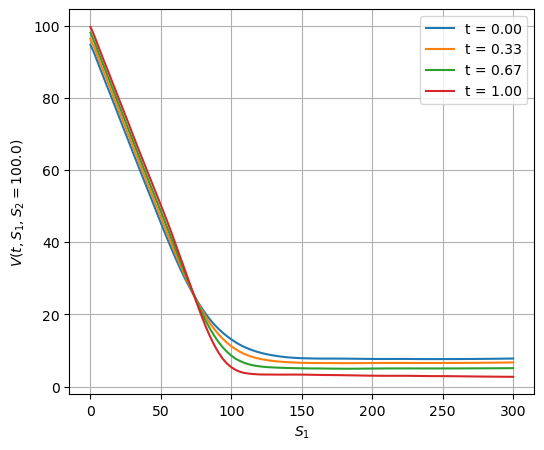

In [69]:
import matplotlib.pyplot as plt

def plot_temporal_slices(model, S2_fixed=100.0, t_list=[0, T/3, 2*T/3, T], n_points=100):
    """
    Trace V(t, S1, S2_fixed) pour plusieurs t donnés.
    """
    S1_vals = np.linspace(S_low, S_high, n_points).reshape(-1, 1)
    S2_vals = np.full_like(S1_vals, S2_fixed)

    plt.figure(figsize=(6, 5))

    for t in t_list:
        t_vals = np.full_like(S1_vals, t)
        inputs = [tf.convert_to_tensor(t_vals, dtype=tf.float32),
                  tf.convert_to_tensor(S1_vals, dtype=tf.float32),
                  tf.convert_to_tensor(S2_vals, dtype=tf.float32)]

        with tf.device("/cpu:0"):
            preds = model(*inputs).numpy()

        plt.plot(S1_vals, preds, label=f"t = {t:.2f}")

    plt.xlabel(r"$S_1$")
    plt.ylabel(r"$V(t, S_1, S_2 = %.1f)$" % S2_fixed)
    plt.legend()
    plt.grid(True)
    plt.savefig("CH2_PUT_WO_5050_slices.png", dpi=300)
    plt.show()

plot_temporal_slices(model, S2_fixed=100)

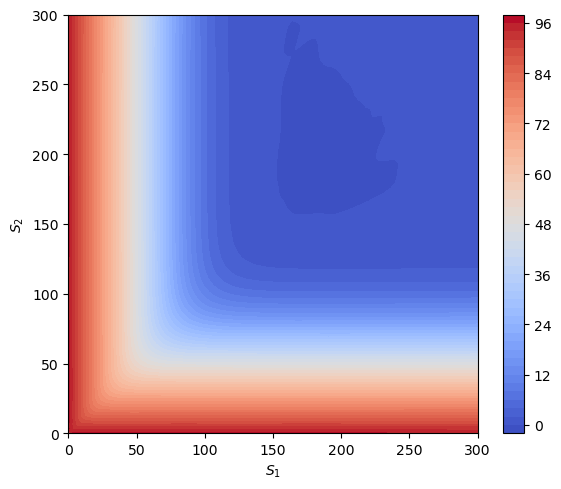

In [71]:
import numpy as np
import matplotlib.pyplot as plt

def plot_contour_solution(model, t_fixed=1.0, n_grid=100):
    """
    Trace une heatmap 2D de la solution V(t, S1, S2) à temps fixé (par défaut maturité t=1).
    """
    S1 = np.linspace(S_low, S_high, n_grid)
    S2 = np.linspace(S_low, S_high, n_grid)
    S1_grid, S2_grid = np.meshgrid(S1, S2)

    t_vals = t_fixed * np.ones_like(S1_grid)

    # Préparation des inputs
    t_input = tf.convert_to_tensor(t_vals.reshape(-1, 1), dtype=tf.float32)
    S1_input = tf.convert_to_tensor(S1_grid.reshape(-1, 1), dtype=tf.float32)
    S2_input = tf.convert_to_tensor(S2_grid.reshape(-1, 1), dtype=tf.float32)

    # Prédiction
    with tf.device("/cpu:0"):
        V_pred = model(t_input, S1_input, S2_input).numpy().reshape(n_grid, n_grid)

    # Affichage
    plt.figure(figsize=(6, 5))
    contour = plt.contourf(S1_grid, S2_grid, V_pred, levels=50, cmap="coolwarm")
    plt.xlabel("$S_1$")
    plt.ylabel("$S_2$")
    #plt.title(f"Option value at t = {t_fixed}")
    plt.colorbar(contour)
    plt.savefig("CH2_PUT_WO_2D_5050_033.png", dpi=300)
    plt.tight_layout()
    plt.show()

plot_contour_solution(model, t_fixed=0.33)

In [75]:
def plot_surface_time_vs_S1(model, S2_fixed=100.0, n_points=100):
    """
    Trace V(t, S1, S2_fixed) en surface 3D (t sur x, S1 sur y, V sur z)
    """
    t_vals = np.linspace(t_low, T, n_points)
    S1_vals = np.linspace(S_low, S_high, n_points)

    T_grid, S1_grid = np.meshgrid(t_vals, S1_vals)
    S2_grid = S2_fixed * np.ones_like(T_grid)

    t_input = tf.convert_to_tensor(T_grid.reshape(-1, 1), dtype=tf.float32)
    S1_input = tf.convert_to_tensor(S1_grid.reshape(-1, 1), dtype=tf.float32)
    S2_input = tf.convert_to_tensor(S2_grid.reshape(-1, 1), dtype=tf.float32)

    with tf.device("/cpu:0"):
        V_pred = model(t_input, S1_input, S2_input).numpy().reshape(n_points, n_points)

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(T_grid, S1_grid, V_pred, cmap="coolwarm", edgecolor="none")
    ax.set_xlabel("t")
    ax.set_ylabel("$S_1$")
    ax.set_zlabel(f"$V(t, S_1, S_2 = {S2_fixed})$",labelpad=1)
    #ax.set_title("Surface plot of option value over time and $S_1$")
    plt.savefig("CH2_PUT_WO_5050_S2100.png", dpi=300)
    plt.tight_layout()
    plt.show()

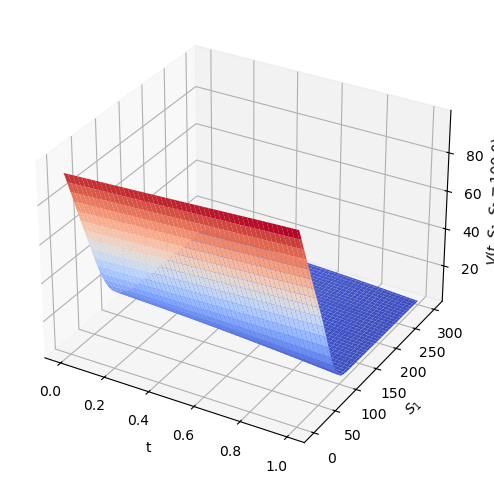

In [77]:
plot_surface_time_vs_S1(model, S2_fixed=100.0)

In [79]:
def monte_carlo_min_put(S1, S2, t, K, T, r, sigma1, sigma2, rho=0.0, n_paths=1000000, seed=42):
    np.random.seed(seed)
    dt = T - t
    S1 = np.array(S1).reshape(-1, 1)
    S2 = np.array(S2).reshape(-1, 1)
    n_samples = S1.shape[0]
    Z1 = np.random.randn(n_samples, n_paths)
    Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.randn(n_samples, n_paths)
    S1_T = S1 * np.exp((r - 0.5 * sigma1**2) * dt + sigma1 * np.sqrt(dt) * Z1)
    S2_T = S2 * np.exp((r - 0.5 * sigma2**2) * dt + sigma2 * np.sqrt(dt) * Z2)
    payoff = np.maximum(K - np.minimum(S1_T, S2_T), 0)
    return np.exp(-r * dt) * np.mean(payoff, axis=1)

# Grille S1/S2
n_grid = 50
S1_vals = np.linspace(S_low, S_high, n_grid)
S2_vals = np.linspace(S_low, S_high, n_grid)
S1_grid, S2_grid = np.meshgrid(S1_vals, S2_vals)
S1_flat = S1_grid.flatten()
S2_flat = S2_grid.flatten()

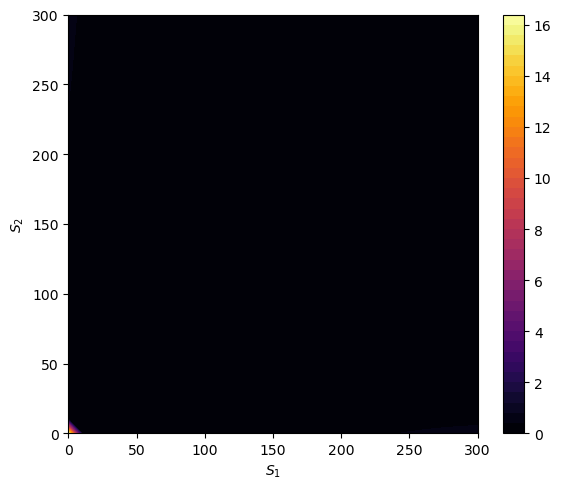

,0.00,10.34,20.69,31.03,41.38,51.72,62.07,72.41,82.76,93.10,...,206.90,217.24,227.59,237.93,248.28,258.62,268.97,279.31,289.66,300.00
0.00,16.366459,0.095609,0.001769,0.215211,0.135834,0.055987,0.027783,0.009326,0.029441,0.124375,...,0.221080,0.246934,0.293568,0.366013,0.437849,0.502876,0.569489,0.635007,0.691072,0.735543
10.34,0.085403,0.026142,0.067559,0.024431,0.100423,0.112967,0.069551,0.073546,0.054833,0.038723,...,0.006403,0.005618,0.010428,0.008646,0.006867,0.038258,0.050050,0.075095,0.095043,0.121632
20.69,0.009989,0.071453,0.015924,0.047436,0.132407,0.037369,0.007581,0.044217,0.015632,0.020263,...,0.007645,0.017798,0.012367,0.004518,0.019878,0.038476,0.030746,0.057565,0.061298,0.087234
31.03,0.057073,0.005631,0.057544,0.079759,0.039920,0.084611,0.032320,0.006247,0.013437,0.012658,...,0.019335,0.007002,0.012049,0.008034,0.010166,0.042084,0.000056,0.008358,0.030903,0.010787
41.38,0.035668,0.028394,0.011830,0.053776,0.020766,0.026923,0.001465,0.074465,0.005573,0.023004,...,0.040769,0.019309,0.032143,0.022852,0.006877,0.035780,0.008958,0.007703,0.042263,0.051040
51.72,0.096452,0.014910,0.013365,0.018984,0.002393,0.114983,0.020617,0.070213,0.088296,0.019837,...,0.070430,0.030241,0.010161,0.034304,0.037837,0.053600,0.114333,0.086074,0.117585,0.117746
62.07,0.135594,0.012395,0.007313,0.000247,0.086658,0.000471,0.045880,0.022544,0.041208,0.111449,...,0.001475,0.034971,0.015702,0.041730,0.027183,0.042245,0.086840,0.097056,0.137138,0.212610
72.41,0.163279,0.006998,0.005665,0.019720,0.035725,0.033679,0.076862,0.075848,0.162953,0.010121,...,0.004268,0.040058,0.075991,0.081519,0.057973,0.100234,0.143643,0.179677,0.211967,0.279864
82.76,0.216151,0.042644,0.022738,0.010903,0.009498,0.071101,0.047647,0.102827,0.133486,0.130360,...,0.075541,0.068947,0.033060,0.061671,0.083166,0.077285,0.141480,0.165670,0.201239,0.194208
93.10,0.240872,0.067844,0.015527,0.027582,0.016154,0.110341,0.128601,0.014512,0.064570,0.149759,...,0.008740,0.018142,0.107052,0.016553,0.079110,0.131078,0.105774,0.130150,0.140474,0.211028


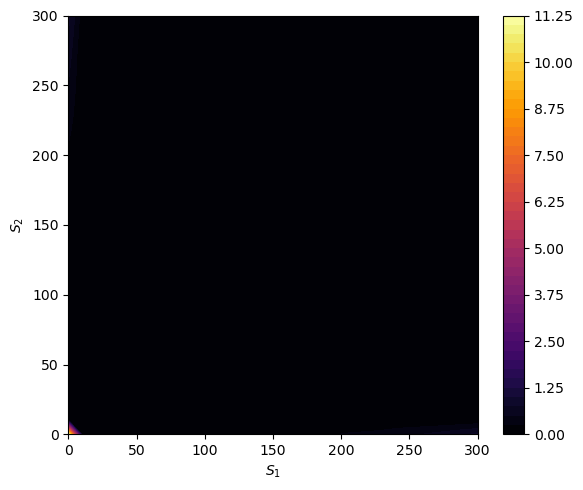

,0.00,10.34,20.69,31.03,41.38,51.72,62.07,72.41,82.76,93.10,...,206.90,217.24,227.59,237.93,248.28,258.62,268.97,279.31,289.66,300.00
0.00,11.193852,0.074105,0.022404,0.177664,0.160831,0.071018,0.055045,0.001174,0.039873,0.106246,...,0.281074,0.301320,0.327729,0.378646,0.438861,0.500358,0.566928,0.642140,0.722932,0.801428
10.34,0.066367,0.088975,0.046152,0.060599,0.106482,0.107841,0.042500,0.006096,0.021868,0.003056,...,0.004729,0.011781,0.025609,0.033255,0.028928,0.011636,0.007323,0.012528,0.029896,0.048656
20.69,0.038051,0.076173,0.009130,0.030106,0.050549,0.035886,0.046814,0.013124,0.032932,0.045186,...,0.027764,0.000584,0.021941,0.006460,0.003900,0.013881,0.002998,0.019566,0.015312,0.030879
31.03,0.006591,0.016315,0.013218,0.029322,0.001753,0.013614,0.057885,0.006836,0.009180,0.021057,...,0.019270,0.010013,0.013288,0.008513,0.011454,0.040645,0.009532,0.005628,0.011270,0.006586
41.38,0.041262,0.028594,0.008588,0.110811,0.068170,0.029766,0.035443,0.003166,0.082679,0.051833,...,0.015701,0.060347,0.063108,0.045301,0.011515,0.039044,0.016407,0.020311,0.017490,0.016344
51.72,0.073587,0.023023,0.008690,0.012792,0.043694,0.005230,0.061790,0.046556,0.016613,0.093932,...,0.024715,0.011952,0.028142,0.006233,0.000943,0.018259,0.065175,0.036437,0.051861,0.044624
62.07,0.088701,0.006063,0.038240,0.013993,0.028901,0.007049,0.008588,0.009282,0.048000,0.000463,...,0.014207,0.006613,0.027043,0.014259,0.035208,0.027678,0.012165,0.013460,0.046573,0.118216
72.41,0.147816,0.005204,0.036002,0.006754,0.007829,0.018300,0.061069,0.008777,0.039071,0.008758,...,0.092935,0.059573,0.019444,0.011722,0.026907,0.003283,0.034508,0.066744,0.084856,0.140399
82.76,0.166743,0.034085,0.052182,0.004454,0.009339,0.000870,0.067707,0.058511,0.013498,0.031936,...,0.004973,0.001913,0.026273,0.007577,0.012801,0.000274,0.054968,0.079400,0.112697,0.112147
93.10,0.204132,0.041723,0.032081,0.006857,0.011265,0.012165,0.049099,0.052866,0.017647,0.039094,...,0.033170,0.027350,0.069719,0.006181,0.047852,0.086528,0.064770,0.094089,0.114060,0.179025


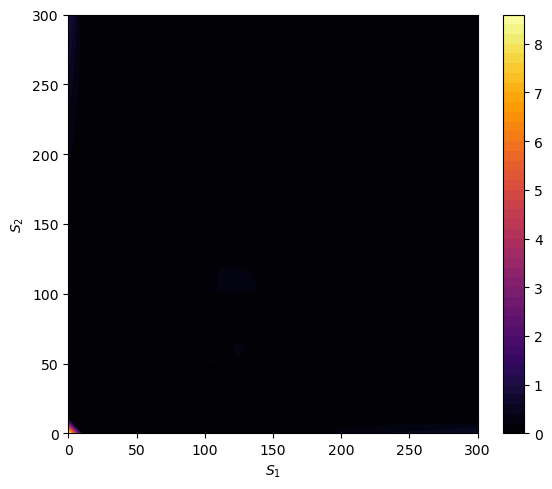

,0.00,10.34,20.69,31.03,41.38,51.72,62.07,72.41,82.76,93.10,...,206.90,217.24,227.59,237.93,248.28,258.62,268.97,279.31,289.66,300.00
0.00,8.467868,0.073193,0.045186,0.175310,0.199529,0.162621,0.133734,0.029560,0.022975,0.089086,...,0.283713,0.318299,0.359741,0.405996,0.436144,0.456107,0.485533,0.531510,0.597237,0.681383
10.34,0.087719,0.078133,0.031295,0.057969,0.132534,0.080418,0.005411,0.029230,0.042703,0.003529,...,0.001443,0.007012,0.019945,0.029234,0.030529,0.023587,0.025653,0.015163,0.004433,0.009734
20.69,0.071121,0.071736,0.015159,0.048554,0.028675,0.054629,0.026120,0.008561,0.042225,0.038160,...,0.028208,0.005589,0.019538,0.007177,0.000011,0.003721,0.005345,0.007678,0.004640,0.014003
31.03,0.039055,0.007766,0.067210,0.005185,0.002884,0.007249,0.096661,0.050847,0.028199,0.000089,...,0.005778,0.007296,0.000368,0.000061,0.004780,0.028142,0.008242,0.006905,0.004870,0.009497
41.38,0.034233,0.014451,0.023688,0.119640,0.027101,0.045688,0.007941,0.009119,0.094154,0.087550,...,0.036039,0.070623,0.075236,0.059957,0.034730,0.054428,0.039579,0.048642,0.024325,0.026591
51.72,0.046848,0.026840,0.050360,0.041166,0.098987,0.035249,0.061498,0.074588,0.009559,0.183541,...,0.018857,0.010142,0.022716,0.010243,0.004764,0.008676,0.037147,0.008376,0.011795,0.003188
62.07,0.034810,0.015712,0.026680,0.035712,0.056441,0.001747,0.071535,0.062610,0.087503,0.047751,...,0.050053,0.062120,0.029903,0.041259,0.022420,0.010233,0.027495,0.013632,0.018064,0.052001
72.41,0.055499,0.015534,0.059274,0.054812,0.003871,0.036104,0.104757,0.052554,0.025029,0.086989,...,0.050229,0.032145,0.000795,0.005894,0.007828,0.010811,0.027792,0.043415,0.030997,0.053213
82.76,0.094582,0.016357,0.066715,0.009977,0.004494,0.003176,0.060090,0.052139,0.056758,0.128836,...,0.063124,0.061786,0.071521,0.065204,0.048648,0.074446,0.036560,0.020372,0.012524,0.021516
93.10,0.114289,0.035316,0.054713,0.030242,0.023234,0.071323,0.057116,0.003772,0.032681,0.008934,...,0.044901,0.037986,0.045719,0.013450,0.030028,0.052637,0.032748,0.050159,0.064654,0.112598


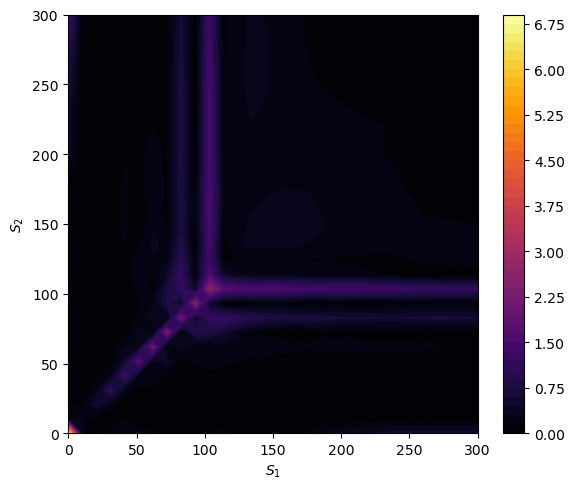

,0.00,10.34,20.69,31.03,41.38,51.72,62.07,72.41,82.76,93.10,...,206.90,217.24,227.59,237.93,248.28,258.62,268.97,279.31,289.66,300.00
0.00,6.767268,0.080050,0.060621,0.182252,0.216160,0.211444,0.182183,0.018190,0.033080,0.097588,...,0.414573,0.446360,0.469244,0.499018,0.551644,0.561321,0.549113,0.546854,0.559650,0.588163
10.34,0.182012,0.311832,0.005956,0.013131,0.160723,0.033473,0.032536,0.006976,0.008052,0.008835,...,0.005708,0.019107,0.031503,0.037725,0.037992,0.038312,0.037239,0.034691,0.031492,0.023866
20.69,0.190557,0.076791,0.624935,0.221482,0.020222,0.100998,0.006203,0.010566,0.074504,0.047865,...,0.011084,0.007223,0.007004,0.005498,0.005696,0.010235,0.013461,0.010940,0.005162,0.000174
31.03,0.067740,0.039647,0.267875,0.996358,0.284489,0.082743,0.107739,0.116541,0.000012,0.031618,...,0.062692,0.050066,0.034488,0.022162,0.010594,0.001128,0.009807,0.013332,0.014250,0.017668
41.38,0.006131,0.008186,0.085890,0.295848,1.254597,0.291163,0.262247,0.089212,0.021277,0.062893,...,0.078910,0.088843,0.100902,0.095981,0.080387,0.067444,0.057267,0.055147,0.057326,0.056848
51.72,0.070031,0.024154,0.069168,0.091400,0.469018,1.620765,0.286179,0.460284,0.086169,0.187036,...,0.024250,0.023863,0.029532,0.034544,0.027318,0.021321,0.005395,0.017658,0.034360,0.047335
62.07,0.052872,0.035118,0.073591,0.044122,0.330713,0.297683,2.002510,0.039761,0.401692,0.178976,...,0.216130,0.197804,0.191278,0.186439,0.186645,0.189670,0.176281,0.145130,0.103620,0.061713
72.41,0.020641,0.057928,0.076133,0.080817,0.025474,0.392133,0.056677,2.214854,0.078670,0.823831,...,0.092424,0.068928,0.072430,0.080708,0.083951,0.068256,0.048663,0.036963,0.030301,0.017175
82.76,0.049619,0.031364,0.048362,0.000103,0.040353,0.180027,0.427991,0.154448,2.025513,0.431865,...,0.612775,0.613383,0.603181,0.598503,0.608327,0.638020,0.660966,0.656731,0.634253,0.600580
93.10,0.164538,0.039781,0.077409,0.065173,0.054492,0.102503,0.304079,0.781526,0.428534,2.327687,...,0.076980,0.072355,0.090373,0.094531,0.107914,0.120040,0.126813,0.140304,0.146196,0.144345


In [109]:
import pandas as pd

for i, t_fixed in enumerate([0.0, T/3, 2*T/3, T]):
    # Monte Carlo
    V_MC_flat = monte_carlo_min_put(S1_flat, S2_flat, t_fixed, K, T, r, sigma1, sigma2, rho, 100000)

    # PINN
    t_tensor = tf.convert_to_tensor(np.full_like(S1_flat, t_fixed).reshape(-1, 1), dtype=tf.float32)
    S1_tensor = tf.convert_to_tensor(S1_flat.reshape(-1, 1), dtype=tf.float32)
    S2_tensor = tf.convert_to_tensor(S2_flat.reshape(-1, 1), dtype=tf.float32)
    V_PINN_flat = model(t_tensor, S1_tensor, S2_tensor).numpy().flatten()

    abs_error = np.abs(V_MC_flat - V_PINN_flat).reshape(n_grid, n_grid)

    # Heatmap
    plt.figure(figsize=(6, 5))
    plt.contourf(S1_grid, S2_grid, abs_error, levels=50, cmap="inferno")
    plt.colorbar()
    plt.xlabel("$S_1$")
    plt.ylabel("$S_2$")
    plt.tight_layout()
    plt.savefig(f"CH2_Put_WO_5050_ERROR_{8+i}4.png", dpi=300)
    plt.show()

    # Tableau d'erreur
    df_error = pd.DataFrame(abs_error, index=np.round(S2_vals, 2), columns=np.round(S1_vals, 2))
    display(df_error)

    # Sauvegarde Excel
    df_error.to_excel(f"CH2_Put_WO_error_table_5050_{8+i}4.xlsx")